# EDA

In [272]:
import pandas as pd
import plotly.express as px
import plotly
import numpy as np
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.ensemble import RandomForestClassifier
from  sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from  sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import model_selection
import rfpimp
import re
import plotly.graph_objects as go

In [273]:
pictureFolderOutput = "../resources/"

In [274]:
df = pd.read_csv("../data/clean/UFC-cleaned.csv", sep=",")

In [275]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 0)

In [276]:
df.head()

,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,...,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Red,True,Bantamweight,5,0.0,4.0,9.200000,6.000000,0.200000,0.000000,62.600000,20.600000,2.600000,2.000000,48.600000,11.200000,0.800000,7.6,5.400000,0.400000,0.000000,65.40,22.600000,0.466000,0.400000,0.80000,0.200000,0.100000,66.400000,23.600000,4.0,1.0,6.400000,4.000000,1.000000,0.60000,51.200000,17.400000,0.600000,0.200000,...,13.300000,8.800000,7.500000,5.100000,90.500000,26.800000,0.800000,0.300000,76.100000,17.300000,0.100000,9.400000,6.100000,0.000000,0.000000,98.800000,32.200000,0.336000,0.000000,0.900000,0.100000,0.050000,110.500000,43.300000,27.0,742.60,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Red,True,Women's Flyweight,5,0.0,3.0,14.600000,9.100000,11.800000,7.300000,124.700000,42.100000,2.400000,1.900000,112.000000,32.000000,0.000000,12.3,10.200000,0.800000,0.000000,138.90,51.300000,0.399000,0.700000,1.00000,0.500000,0.225000,158.700000,69.600000,3.0,6.0,13.000000,9.300000,12.800000,9.60000,101.700000,32.000000,8.100000,6.900000,...,24.571429,14.142857,10.571429,7.857143,98.571429,32.571429,6.428571,4.285714,61.857143,12.428571,0.000000,29.142857,18.142857,1.142857,0.000000,115.571429,44.714286,0.437143,0.285714,3.285714,0.857143,0.147143,158.142857,82.285714,25.0,1062.00,2.0,0.0,1.0,2.0,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Red,False,Lightweight,3,0.0,3.0,15.354839,11.322581,6.741935,4.387097,84.741935,38.580645,5.516129,3.806452,67.645161,23.258065,0.645161,14.0,12.193548,0.935484,0.096774,97.00,46.774194,0.496129,0.354839,2.16129,0.677419,0.295484,103.709677,52.548387,8.0,8.0,17.903226,11.870968,8.419355,5.83871,84.548387,38.064516,1.741935,0.935484,...,14.466667,8.133333,2.800000,0.733333,91.066667,32.200000,4.866667,2.800000,78.266667,23.200000,0.266667,6.000000,4.400000,0.333333,0.133333,98.733333,35.733333,0.340000,0.066667,2.866667,0.666667,0.131333,102.133333,38.600000,33.0,604.40,2.0,0.0,1.0,3.0,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Blue,False,Bantamweight,3,0.0,4.0,17.000000,14.000000,13.750000,11.000000,109.500000,48.750000,13.000000,10.500000,116.250000,53.750000,0.500000,3.0,2.500000,0.500000,0.250000,136.25,70.250000,0.550000,0.250000,2.50000,1.250000,0.287500,154.750000,86.750000,4.0,0.0,12.250000,6.000000,6.000000,3.75000,94.250000,26.750000,1.750000,1.250000,...,20.250000,13.375000,6.875000,5.625000,103.125000,38.500000,0.875000,0.750000,77.375000,20.375000,0.125000,13.250000,11.125000,0.000000,0.000000,110.875000,44.875000,0.446250,0.000000,2.375000,0.000000,0.000000,115.125000,48

# Feature Exploration
1. Correlations
    1. All metrics
    1. Reduced metrics
1. Compare predictions quality for both
1. Prediction

## Overall Statistic

for column in df.columns:
    print('Statistic for', column)
    print(df[column].describe())
    print('---------------------')

## Correlation

### Correlation for all metrics

In [277]:
correlation_matrix = df.corr()

In [278]:
correlation_matrix.head()

,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,...,R_losses,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
title_bout,1.000000,0.637445,-0.143853,0.316009,-0.006543,0.006808,0.003882,0.007960,-0.019275,-0.007171,0.096193,0.097666,0.004701,0.038746,0.077944,-0.010320,-0.012692,0.045049,-0.042745,0.001449,0.025726,0.094484,-0.011892,0.003834,0.057991,0.091131,0.019147,0.049830,0.276373,-0.050144,-0.073187,-0.074565,-0.042538,-0.046499,-0.054542,-0.072815,-0.064633,-0.070408,-0.065914,-0.093655,...,-0.126756,-0.018761,-0.034793,-0.030706,-0.038152,-0.030156,-0.067117,-0.104270,-0.114969,-0.057148,-0.118610,-0.092398,-0.017571,-0.037908,-0.110001,-0.053568,-0.052000,-0.100978,-0.128035,-0.062913,-0.001055,-0.092433,-0.127801,-0.057838,-0.084375,0.100932,0.057180,0.394575,0.046702,-0.003932,0.121940,0.185363,0.071522,0.052248,0.182950,0.021629,0.041271,0.079594,0.045398,0.018817
no_of_rounds,0.637445,1.000000,-0.107887,0.302900,0.080438,0.088073,0.045107,0.049887,0.085152,0.104060,0.092675,0.093213,0.102065,0.131298,0.131399,0.065423,0.066737,0.045448,-0.041941,0.105902,0.131819,0.050229,-0.032500,0.031362,0.058221,0.017118,0.107782,0.114294,0.363800,0.076363,0.027936,0.021337,0.005276,0.003362,0.050540,0.030490,-0.044330,-0.043769,0.038176,0.001942,...,0.025340,0.069901,0.047919,0.009168,0.000659,0.082064,0.047498,-0.073378,-0.073945,0.057707,-0.003844,-0.035680,0.066108,0.045247,-0.083298,-0.051895,0.066063,0.020174,-0.077549,-0.065764,0.049588,-0.043522,-0.104175,0.046555,-0.006934,0.266524,0.140482,0.381014,0.056522,0.058484,0.254782,0.324725,0.061019,0.025091,0.319132,0.031124,0.074105,0.049361,0.122508,0.091420
B_current_lose_streak,-0.143853,-0.107887,1.000000,-0.576231,-0.037919,-0.058263,-0.040125,-0.050812,0.001552,-0.035668,-0.181148,-0.184876,-0.037083,-0.109135,-0.131146,-0.032077,-0.038094,-0.175696,0.001855,-0.040987,-0.101237,-0.156597,-0.070633,-0.068204,-0.135297,-0.136647,-0.064469,-0.107184,-0.158558,0.346936,0.056673,0.084550,0.070256,0.078849,0.040578,0.082461,0.200061,0.200914,0.088916,0.171288,...,0.121867,-0.002326,0.027767,0.042607,0.049447,-0.005476,0.025191,0.140100,0.146002,0.034167,0.099252,0.078951,-0.010598,0.000157,0.128209,0.032880,0.026453,0.076555,0.126250,0.067953,0.019200,0.097736,0.114978,0.054270,0.102154,-0.039573,-0.024092,-0.086140,-0.033170,-0.008358,-0.102084,-0.086463,-0.059679,-0.032274,-0.118634,0.014977,0.001467,0.012279,0.134737,0.011790
B_current_win_streak,0.316009,0.302900,-0.576231,1.000000,0.043472,0.053080,0.016529,0.023525,0.026867,0.055296,0.219438,0.225219,0.071042,0.138427,0.176333,0.041498,0.046734,0.172540,-0

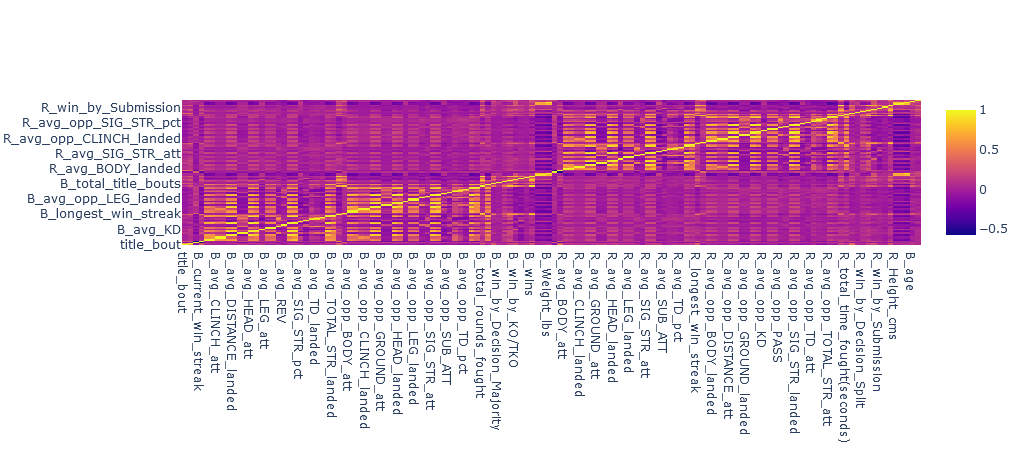

In [279]:
fig = go.Figure(data=go.Heatmap(x=correlation_matrix.columns, y=correlation_matrix.columns,z=correlation_matrix))
fig.show()

Printing a correlation matrix with so many features doesn't make sense.

### Get highest correlations
from https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

In [280]:
def show_high_corr(df_input):
    corr_matrix = df_input.corr().abs()
    #the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                     .stack()
                     .sort_values(ascending=False))
    #first element of sol series is the pair with the bigest correlation
    return sol

In [281]:
sol = show_high_corr(df)
sol.head(50)

R_avg_opp_HEAD_att         R_avg_opp_SIG_STR_att        0.984553
B_avg_opp_HEAD_att         B_avg_opp_SIG_STR_att        0.982878
B_avg_HEAD_att             B_avg_SIG_STR_att            0.979632
B_avg_LEG_att              B_avg_LEG_landed             0.979291
R_avg_HEAD_att             R_avg_SIG_STR_att            0.978031
B_avg_opp_LEG_att          B_avg_opp_LEG_landed         0.977537
R_avg_LEG_att              R_avg_LEG_landed             0.976025
R_avg_opp_LEG_att          R_avg_opp_LEG_landed         0.972444
R_avg_opp_DISTANCE_att     R_avg_opp_SIG_STR_att        0.971328
R_avg_CLINCH_att           R_avg_CLINCH_landed          0.969919
R_avg_GROUND_att           R_avg_GROUND_landed          0.969339
B_avg_CLINCH_att           B_avg_CLINCH_landed          0.968278
B_avg_opp_DISTANCE_att     B_avg_opp_SIG_STR_att        0.967814
B_avg_opp_CLINCH_att       B_avg_opp_CLINCH_landed      0.966826
R_avg_opp_CLINCH_att       R_avg_opp_CLINCH_landed      0.964298
B_avg_GROUND_att         

Many unnecessary correlations found...
Also attempts and landed should be combined into one percentage to reduce features.

## Correlation with reduced metrics

### Calculate landed percentage
1. Sort columns by name
1. Divide landed / attempts
1. Drop the landed and attempts columns

In [282]:
df2 = df.reindex(sorted(df.columns), axis=1)

In [283]:
# check if _att comes before _landed. Compare prefixes to be sure to have the correct values
for i in df2.columns:
    if re.search(".*_att", i):
        att_save = i[:-4] #first part of the keyword
        att_value_save = df2[i] #value of the column for later use
        continue
    if re.search(".*_landed", i) and (i[:-7] == att_save): # found landed, compare the first part of the key if landed and att match
        df2[att_save+"_pct"] = df2[i] / att_value_save
        df2[att_save+"_pct"] = df2[att_save+"_pct"].fillna(0)
        att_save = ""

In [284]:
df2 = df2.reindex(sorted(df2.columns), axis=1)
df2

,B_Height_cms,B_Reach_cms,B_Stance,B_Weight_lbs,B_age,B_avg_BODY_att,B_avg_BODY_landed,B_avg_BODY_pct,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_CLINCH_pct,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_DISTANCE_pct,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_GROUND_pct,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_HEAD_pct,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_LEG_pct,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_avg_TOTAL_STR_pct,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_BODY_pct,B_avg_opp_CLINCH_att,...,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_GROUND_pct,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_HEAD_pct,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_LEG_pct,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_avg_opp_TOTAL_STR_pct,R_current_lose_streak,R_current_win_streak,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,Winner,no_of_rounds,title_bout,weight_class
0,167.64,170.18,Orthodox,135.0,31.0,9.200000,6.000000,0.652174,0.200000,0.000000,0.000000,62.600000,20.600000,0.329073,2.600000,2.000000,0.769231,48.600000,11.200000,0.230453,0.800000,7.6,5.400000,0.710526,0.400000,0.000000,65.40,22.600000,0.345566,0.400000,0.80000,0.200000,0.250000,66.400000,23.600000,0.355422,6.400000,4.000000,0.625000,1.000000,...,0.800000,0.300000,0.375000,76.100000,17.300000,0.227332,0.100000,9.400000,6.100000,0.648936,0.000000,0.000000,98.800000,32.200000,0.325911,0.000000,0.900000,0.100000,0.111111,110.500000,43.300000,0.391855,0.0,4.0,4.0,2.0,27.0,742.60,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,Red,5,True,Bantamweight
1,167.64,167.64,Orthodox,125.0,32.0,14.600000,9.100000,0.623288,11.800000,7.300000,0.618644,124.700000,42.100000,0.337610,2.400000,1.900000,0.791667,112.000000,32.000000,0.285714,0.000000,12.3,10.200000,0.829268,0.800000,0.000000,138.90,51.300000,0.369330,0.700000,1.00000,0.500000,0.500000,158.700000,69.600000,0.438563,13.000000,9.300000,0.715385,12.800000,...,6.428571,4.285714,0.666667,61.857143,12.428571,0.200924,0.000000,29.142857,18.142857,0.622549,1.142857,0.000000,115.571429,44.714286,0.386897,0.285714,3.285714,0.857143,0.260870,158.142857,82.285714,0.520325,0.0,2.0,2.0,2.0,25.0,1062.00,2.0,0.0,1.0,2.0,0.0,2.0,0.0,5.0,Red,5,True,Women's Flyweight
2,185.42,185.42,Orthodox,155.0,36.0,15.354839,11.322581,0.737395,6.741935,4.387097,0.650718,84.741935,38.580645,0.455272,5.516129,3.806452,0.690058,67.645161,23.258065,0.343825,0.645161,14.0,12.193548,0.870968,0.935484,0.096774,97.00,46.774194,0.482208,0.354839,2.16129,0.677419,0.313433,103.709677,52.548387,0.506687,17.903226,11.870968,0.663063,8.419355,...,4.866667,2.800000,0.575342,78.266667,23.200000,0.296422,0.266667,6.000000,4.400000,0.733333,0.333333,0.133333,98.733333,35.733333,0.361918,0.066667,2.866667,0.666667,0.232558,102.133333,38.600000,0.377937,0.0,11.0,11.0,1.0,33.0,604.40,2.0,0.0,1.0,3.0,3.0,6.0,1.0,14.0,Red,3,False,Lightweight
3,170.18,170.18,Switch,135.0,26.0,17.000000,14.000000,0.823529,13.750000,11.000000,0.800000,109.500000,48.750000,0.445205,13.000000,10.500000,0.807692,116.250000,53.750000,0.462366,0.500000,3.0,2.500000,0.833333,0.500000,0.250000,136.25,70.250000,0.515596,0.250000,2.50000,1.250000,0.500000,154.750000,86.750000,0.560582,12.250000,6.000000,0.489796,6.000000,...,0.875000,0.750000,0.857143,77.375000,20.375000,0.263328,0.125000,13.250000,11.125000,0.839623,0.000000,0.000000,110.875000,44.875000,0.404735,0.000000,2.375000,0.000000,0.000000,115.125000,48.875000,0.424539,1.0,0.0,5.0,2.0,20.0,690.25,0.0,0.0,1.0,4

In [285]:
# now drop _att and _landed columns if the pct columns is found afterwards
drop_columns = []
for i in df2.columns:
#    print(i)
    if re.search(".*_att", i):
        att_save_pre = i[:-4]
        att_save = i
        continue
    if re.search(".*_landed", i) and (i[:-7] == att_save_pre):
        landed_save_pre = i[:-7]
        landed_save = i
        continue
    if re.search(".*_pct", i) and (i[:-4] == att_save_pre) and (i[:-4] == landed_save_pre):
        df3 = df2.drop([att_save, landed_save], axis=1)
        drop_columns.append(att_save)
        drop_columns.append(landed_save)
        att_save = ""
        landed_save = ""
df2.drop(drop_columns, axis=1, inplace=True)

### Reduced correlation matrix

df.drop('', axis=1, inplace=true)

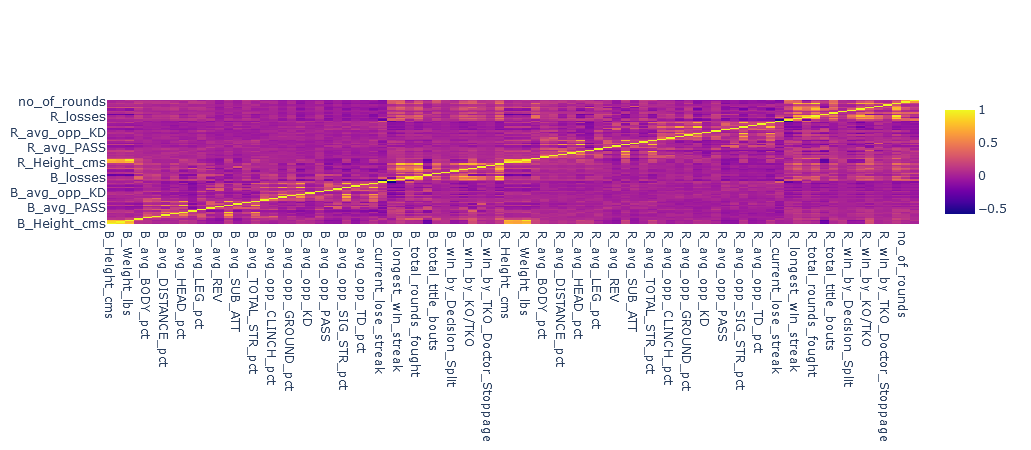

In [286]:
correlation_matrix = df2.corr()
fig = go.Figure(data=go.Heatmap(x=correlation_matrix.columns, y=correlation_matrix.columns,z=correlation_matrix))
fig.show()

In [287]:
sol = show_high_corr(df2)
sol.head(50)

B_Weight_lbs                 R_Weight_lbs                   0.934506
B_total_rounds_fought        B_wins                         0.917830
R_total_rounds_fought        R_wins                         0.917245
R_Height_cms                 R_Reach_cms                    0.894118
R_avg_HEAD_pct               R_avg_SIG_STR_pct              0.892208
B_Height_cms                 B_Reach_cms                    0.883699
B_avg_HEAD_pct               B_avg_SIG_STR_pct              0.862440
R_avg_opp_HEAD_pct           R_avg_opp_SIG_STR_pct          0.859776
B_longest_win_streak         B_wins                         0.838802
B_losses                     B_total_rounds_fought          0.825168
B_avg_opp_HEAD_pct           B_avg_opp_SIG_STR_pct          0.823150
R_longest_win_streak         R_wins                         0.813536
B_avg_opp_SIG_STR_pct        B_avg_opp_TOTAL_STR_pct        0.806160
R_losses                     R_total_rounds_fought          0.802834
R_avg_SIG_STR_pct            R_avg

The chart is still not usable, but the table is.
We still see a lot of unneccessary correlations like B_Weight_lbs and R_Weight_lbs which is obvious because they fight in the same weight classes.

## Compare predictions

### Define categories for one hot encoding
df and df2 are equal in this point

In [288]:
df.B_Stance.value_counts()

Orthodox       2762
Southpaw        709
Switch          114
Open Stance       5
Sideways          2
Name: B_Stance, dtype: int64

In [289]:
df.R_Stance.value_counts()

Orthodox       2724
Southpaw        757
Switch           99
Open Stance      12
Name: R_Stance, dtype: int64

In [290]:
df.weight_class.value_counts()

Lightweight              703
Welterweight             696
Middleweight             518
Light Heavyweight        361
Heavyweight              327
Featherweight            321
Bantamweight             265
Flyweight                141
Women's Strawweight       98
Women's Bantamweight      71
Open Weight               35
Women's Flyweight         29
Catch Weight              23
Women's Featherweight      4
Name: weight_class, dtype: int64

Weight_class and stances should be categories

In [291]:
categorical_columns = ["Winner", "weight_class", "B_Stance", "R_Stance"]

In [292]:
for col in categorical_columns:
    df[col] = df[col].astype('category')
    df2[col] = df2[col].astype('category')

In [293]:
df = pd.get_dummies(df, drop_first=True)
df2 = pd.get_dummies(df2, drop_first=True)

### Random Forest - Reduced

In [294]:
X = df2.drop('Winner_Red', axis=1)
y = df2.Winner_Red

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [296]:
rfc = RandomForestClassifier()

In [297]:
rfc.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [298]:
rfc_scores = cross_validate(rfc, X, y.values.ravel(), cv=5, scoring=('accuracy', 'average_precision', 'recall','f1'))
rfc_scores

{'fit_time': array([1.40345454, 1.70987248, 2.56732368, 2.48954248, 2.38839793]),
 'score_time': array([0.07044363, 0.09653687, 0.11482906, 0.13165808, 0.10681963]),
 'test_accuracy': array([0.64116829, 0.6689847 , 0.6448468 , 0.66713092, 0.66852368]),
 'test_average_precision': array([0.72958105, 0.71536222, 0.69264625, 0.76210974, 0.67493259]),
 'test_recall': array([0.7289916 , 0.8802521 , 0.8907563 , 0.95378151, 1.        ]),
 'test_f1': array([0.7289916 , 0.77881041, 0.76881233, 0.79163034, 0.8       ])}

### Random Forest - Full

In [299]:
X = df.drop('Winner_Red', axis=1)
y = df.Winner_Red

In [300]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [301]:
rfc = RandomForestClassifier()

In [302]:
rfc.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [303]:
rfc_scores = cross_validate(rfc, X, y.values.ravel(), cv=5, scoring=('accuracy', 'average_precision', 'recall','f1'))
rfc_scores

{'fit_time': array([3.28990054, 3.43292689, 3.64139509, 3.54666519, 3.47567034]),
 'score_time': array([0.12566018, 0.17820001, 0.13801003, 0.12238359, 0.12268996]),
 'test_accuracy': array([0.57858136, 0.64255911, 0.62256267, 0.67688022, 0.6545961 ]),
 'test_average_precision': array([0.73034488, 0.72415843, 0.72267189, 0.7985703 , 0.72449617]),
 'test_recall': array([0.6512605 , 0.82563025, 0.82352941, 0.94957983, 0.97478992]),
 'test_f1': array([0.67172264, 0.7535954 , 0.74312796, 0.79577465, 0.78911565])}

## Prediction conclusion

### Data decision
The scores between df and df2 aren't really different, so we can move on with the full dataset. Dismiss df2.

The prediction accuracy is only around 60% to 70%, which is pretty useless.

importance = rfpimp.importances(rfc, X_test, y_test)

importance

### Save the model and data

In [304]:
pickle.dump(rfc, open('../models/rfc.model', 'wb'))

In [305]:
df.to_csv("../data/clean/UFC-processed.csv", index=False)

## Everything about the winners

In [306]:
df_w_fighter = pd.read_csv("../data/clean/UFC-cleaned-with-fighternames.csv")

In [307]:
df_w_fighter

,WinnerName,WinnerAge,winner_Height,winner_Weight,winner_Reach,winner_Stance,winner_DOB,WinningDate,title_bout
0,Henry Cejudo,32.0,"5' 4""",135 lbs.,"64""",Orthodox,"Feb 09, 1987",2019-06-08,True
1,Valentina Shevchenko,31.0,"5' 5""",125 lbs.,"66""",Southpaw,"Mar 07, 1988",2019-06-08,True
2,Tony Ferguson,35.0,"5' 11""",155 lbs.,"76""",Orthodox,"Feb 12, 1984",2019-06-08,False
3,Petr Yan,26.0,"5' 7""",135 lbs.,"67""",Switch,"Feb 11, 1993",2019-06-08,False
4,Blagoy Ivanov,32.0,"5' 11""",250 lbs.,"73""",Southpaw,"Oct 09, 1986",2019-06-08,False
...,...,...,...,...,...,...,...,...,...
3587,Remco Pardoel,30.0,"6' 3""",260 lbs.,NaN,Southpaw,NaN,1994-03-11,False
3588,Patrick Smith,30.0,"6' 2""",225 lbs.,NaN,Orthodox,"Aug 28, 1963",1994-03-11,False
3589,Royce Gracie,26.0,"6' 1""",175 lbs.,NaN,Southpaw,"Dec 12, 1966",1993-11-12,True
3590,Royce Gracie,26.0,"6' 1""",175 lbs.,NaN,Southpaw,"Dec 12, 1966",1993-11-12,False


### Most wins

In [308]:
def createTopWinners():
    mostwinners = []
    mostwinners = df_w_fighter.groupby("WinnerName").count().reset_index()
    #just create a dummy for the counts
    mostwinners["Wins"] = mostwinners.WinningDate
    mostwinners = mostwinners[["WinnerName", "Wins"]]
    mostwinners = mostwinners.sort_values(by="Wins", ascending=False)
    return mostwinners

In [309]:
mostwinners = createTopWinners()
mostwinners.head(10)

,WinnerName,Wins
621,Michael Bisping,19
246,Donald Cerrone,19
226,Demian Maia,18
727,Rafael Dos Anjos,18
449,Jon Jones,17
320,Georges St-Pierre,17
416,Jim Miller,16
45,Anderson Silva,16
329,Gleison Tibau,15
303,Frankie Edgar,15


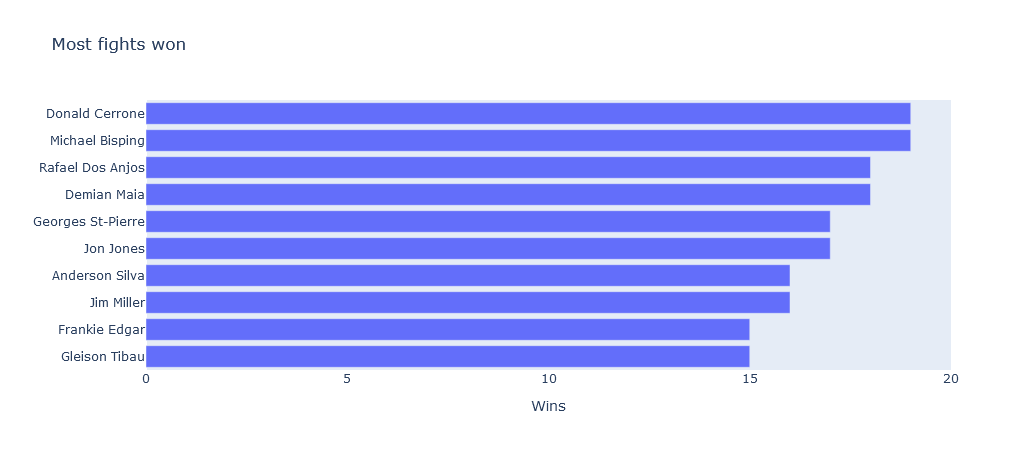

In [310]:
# Not too good bar chart -> no values on bars
fig = px.bar(mostwinners.head(10).sort_values(by="Wins"), y="WinnerName", x="Wins", orientation="h", title="Most fights won")
fig = fig.update_yaxes(title_text='')
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)
#fig.write_image(pictureFolderOutput + "MostFightsWon.png")
fig.show()

In [311]:
def print_barchart(cat, val, title):
    fig = go.Figure(data=[go.Bar(
                x=val, y=cat,
                text=val,
                orientation="h",
                textposition='auto'
            )])
    fig.update_layout(title_text=title)
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)
    fig.show()
    return fig

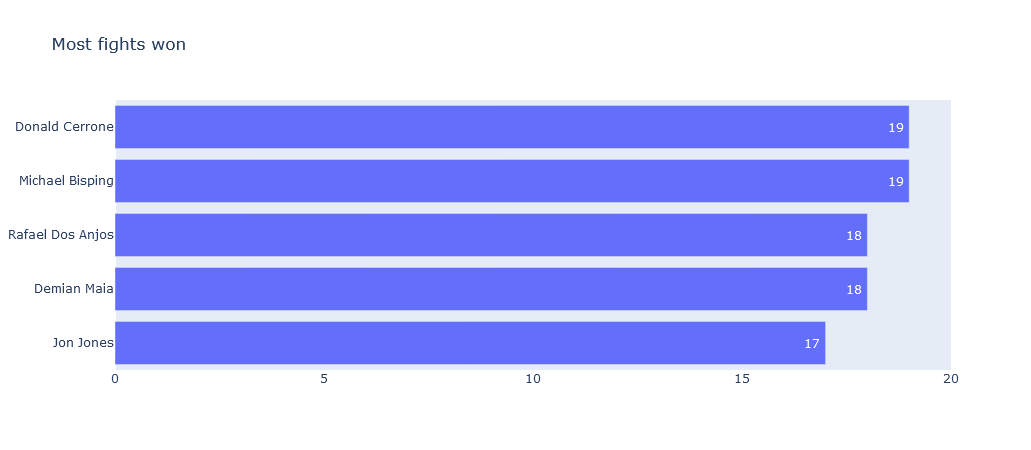

In [312]:
fig = print_barchart(mostwinners.head(5).sort_values(by="Wins").WinnerName,
                     mostwinners.head(5).sort_values(by="Wins").Wins,
                     "Most fights won")
fig.write_image(pictureFolderOutput + "MostFightsWon.png")

### Age of winners

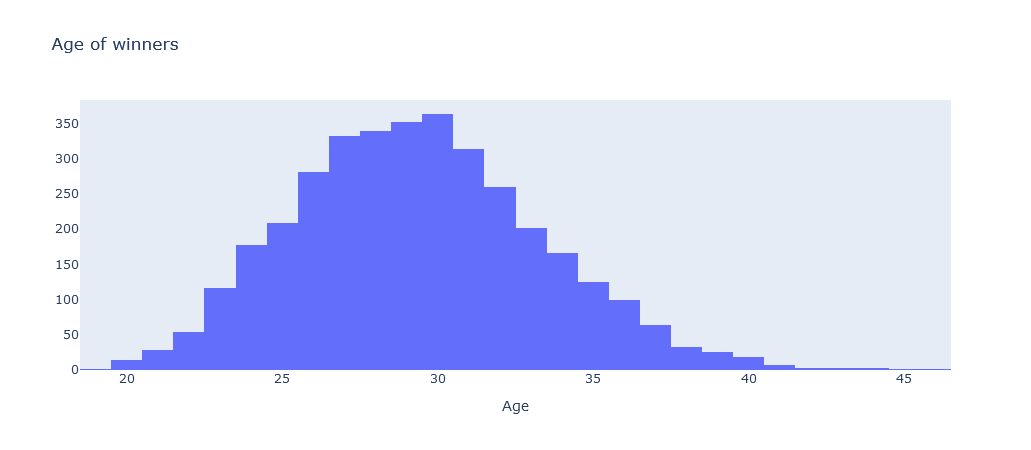

In [313]:
# bad, no values inside bars...
fig = px.histogram(df_w_fighter, x="WinnerAge", title="Age of winners")
fig = fig.update_xaxes(title_text='Age')
fig = fig.update_yaxes(title_text='')
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)
#fig.write_image(pictureFolderOutput + "WinnersAge.png")
fig.show()

histogram_fake = pd.DataFrame(columns=["WinnerAge", "Wins"])
histogram_fake

In [314]:
histogram_fake = df_w_fighter.WinningDate.groupby(df_w_fighter.WinnerAge).count().reset_index()

In [315]:
histogram_fake["Wins"] = histogram_fake.WinningDate
histogram_fake = histogram_fake.drop(labels="WinningDate", axis=1)

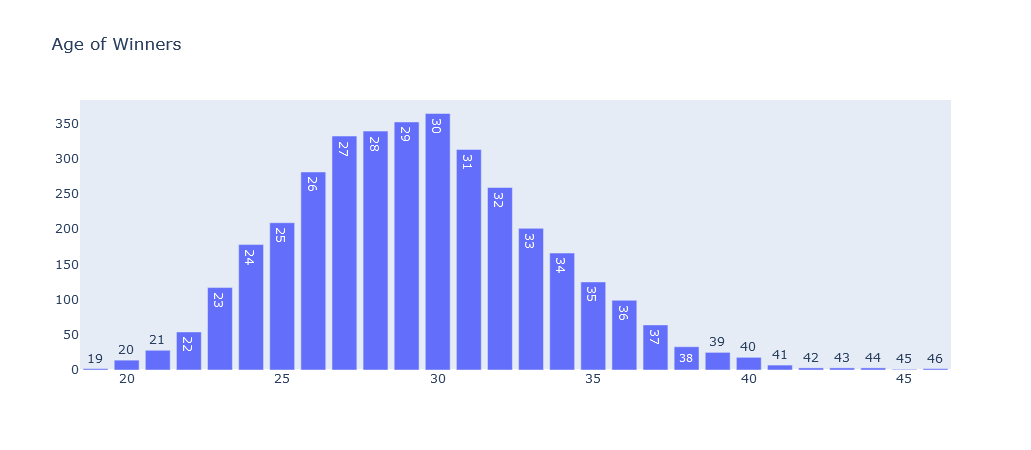

In [316]:
fig = go.Figure(data=[go.Bar(
                x=histogram_fake.WinnerAge, y=histogram_fake.Wins,
                text=histogram_fake.WinnerAge,
                orientation="v",
                textposition='auto'
        )])
fig.update_layout(title_text="Age of Winners")
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)
fig.show()
fig.write_image(pictureFolderOutput + "WinnersAge.png")

### Most title fights won

In [317]:
df_w_fighter = df_w_fighter[df_w_fighter.title_bout == True]

In [318]:
mostwinners = createTopWinners()
mostwinners.head(10)

,WinnerName,Wins
31,Georges St-Pierre,13
42,Jon Jones,12
20,Demetrious Johnson,12
1,Anderson Silva,11
70,Randy Couture,10
57,Matt Hughes,7
43,Jose Aldo,7
85,Tito Ortiz,6
40,Joanna Jedrzejczyk,6
19,Daniel Cormier,6


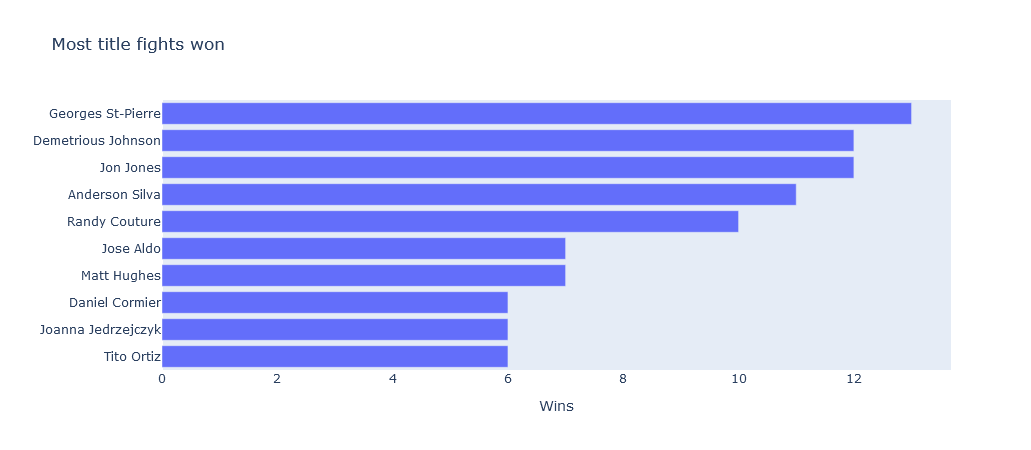

In [319]:
fig = px.bar(mostwinners.head(10).sort_values(by="Wins"), y="WinnerName", x="Wins", orientation="h", title="Most title fights won")
fig = fig.update_yaxes(title_text='')
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)
#fig.write_image(pictureFolderOutput + "MostTitleFightsWon.png")
fig.show()

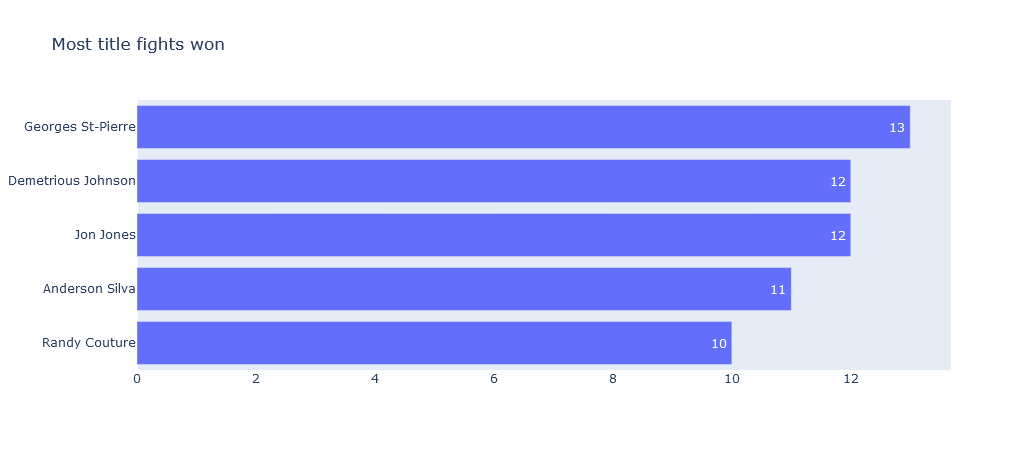

In [320]:
# better way of bar charts
fig = print_barchart(mostwinners.head(5).sort_values(by="Wins").WinnerName,
                     mostwinners.head(5).sort_values(by="Wins").Wins,
                     "Most title fights won")
fig.write_image(pictureFolderOutput + "MostTitleFightsWon.png")